In [38]:
from networks import CNN
from preprocessing import *

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
class ArtifactDataset(Dataset):
    """PyTorch Dataset of Artifact Images"""

    def __init__(self, images, labels, metadata, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.metadata = metadata

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        objid = self.metadata.OBJID[idx]
        
        sample = {'image': image, 'label': label, 'objid': objid}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image_, label, objid = sample['image'], sample['label'], sample['objid']

        scaled_array = (image_ - np.mean(image_,axis=(-1,-2),keepdims=True))/(10*np.std(image_,axis=(-1,-2),keepdims=True)) + 0.5
        return {'image': torch.from_numpy(scaled_array).float(),
                'label': torch.from_numpy(label),
                'objid': torch.from_numpy(np.asarray(objid))}

In [3]:
X_train0_0, X_test0_0, y_train0_0, y_test0_0, mdtrain0_0, mdtest0_0 = TrainTest('TS__2020-11-25_19-38-15/Class_0_images.h5','TS__2020-11-25_19-38-15/Class_0_metadata.csv',100,371,0)
X_train0_2, X_test0_2, y_train0_2, y_test0_2, mdtrain0_2, mdtest0_2 = TrainTest('Real__20-07-11_21-31-43/s200224ca_images.h5','Real__20-07-11_21-31-43/s200224ca_metadata.csv',100,214,0)

mdtrain0_2['ACTION'] = ['Good' for i in range(len(mdtrain0_2))]
mdtest0_2['ACTION'] = ['Good' for i in range(len(mdtest0_2))]

X_train0, X_test0 = np.concatenate((X_train0_0,X_train0_2)), np.concatenate((X_test0_0,X_test0_2))
y_train0, y_test0 = np.concatenate((y_train0_0,y_train0_2)), np.concatenate((y_test0_0,y_test0_2))
mdtrain0, mdtest0 = pd.concat([mdtrain0_0,mdtrain0_2]), pd.concat([mdtest0_0,mdtest0_2])
images_0 = np.concatenate((X_train0_0,X_train0_2,X_test0_0,X_test0_2))
y_0 = np.concatenate((y_train0_0, y_train0_2, y_test0_0, y_test0_2))
md_0 = pd.concat([mdtrain0,mdtest0]).reset_index()

X_train1, X_test1, y_train1, y_test1, mdtrain1, mdtest1 = TrainTest('TS__2020-11-25_19-38-15/Class_1_images.h5','TS__2020-11-25_19-38-15/Class_1_metadata.csv',500,1000,0)
images_1 = np.concatenate((X_train1, X_test1))
y_1 = np.concatenate((y_train1, y_test1))
md_1 = pd.concat([mdtrain1, mdtest1])

X_train3, X_test3, y_train3, y_test3, mdtrain3, mdtest3 = TrainTest('TS__2020-11-25_19-38-15/Class_3_images.h5','TS__2020-11-25_19-38-15/Class_3_metadata.csv',450,1450,1)
images_3 = np.concatenate((X_train3, X_test3))
y_3 = np.concatenate((y_train3, y_test3))
md_3 = pd.concat([mdtrain3, mdtest3])

X_train4, X_test4, y_train4, y_test4, mdtrain4, mdtest4 = TrainTest('TS__2020-11-25_19-38-15/Class_4_images.h5','TS__2020-11-25_19-38-15/Class_4_metadata.csv',274,363,0)
images_4 = np.concatenate((X_train4, X_test4))
y_4 = np.concatenate((y_train4, y_test4))
md_4 = pd.concat([mdtrain4, mdtest4])

X_train5, X_test5, y_train5, y_test5, mdtrain5, mdtest5 = TrainTest('TS__2020-11-25_19-38-15/Class_5_images.h5','TS__2020-11-25_19-38-15/Class_5_metadata.csv',274,368,0)
images_5 = np.concatenate((X_train5, X_test5))
y_5 = np.concatenate((y_train5, y_test5))
md_5 = pd.concat([mdtrain5, mdtest5])

X_train6, X_test6, y_train6, y_test6, mdtrain6, mdtest6 = TrainTest('TS__2020-11-25_19-38-15/Class_6_images.h5','TS__2020-11-25_19-38-15/Class_6_metadata.csv',362,1100,0)
images_6 = np.concatenate((X_train6, X_test6))
y_6 = np.concatenate((y_train6, y_test6))
md_6 = pd.concat([mdtrain6, mdtest6])

In [5]:
md_4.keys()

Index(['MJD', 'FLT', 'FLUXCAL', 'FLUXCALERR', 'PHOTFLAG', 'PHOTPROB', 'ZPFLUX',
       'PSF', 'SKYSIG', 'SKYSIG_T', 'GAIN', 'XPIX', 'YPIX', 'EXPNUM', 'CCDNUM',
       'SNID', 'ACTION', 'COMMENT', 'TIME', 'USER', 'OBJID_COPY', 'BATCH',
       'OBJID'],
      dtype='object')

In [21]:
class0_centers = CenterFlux(images_0,md_0)
class1_centers = CenterFlux(images_1,md_1)
class3_centers = CenterFlux(images_3,md_3)
class4_centers = CenterFlux(images_4,md_4)
class5_centers = CenterFlux(images_5,md_5)
class6_centers = CenterFlux(images_6,md_6)
good_centers = np.concatenate((class0_centers, class1_centers, class3_centers, class6_centers))
notgood_centers = np.concatenate((class4_centers, class5_centers))
md_good = pd.concat([md_0, md_1, md_3, md_6], ignore_index=True)
md_notgood = pd.concat([md_4,md_5], ignore_index=True)
purity_centers, completeness_centers = [], []
thresholds = np.linspace(np.concatenate((good_centers, notgood_centers)).min(), 
                         np.concatenate((good_centers, notgood_centers)).max(), 1000)
for threshold in thresholds:
    tp = np.sum(good_centers > threshold)
    fn = np.sum(good_centers < threshold)
    fp = np.sum(notgood_centers > threshold)
    purity_centers.append(tp / (tp + fp))
    completeness_centers.append(tp / (tp + fn))
desired_completeness = 0.99
center_thres = thresholds[np.argmin(np.abs(np.array(completeness_centers) - desired_completeness))]


thresgood_snr = SNR(md_good.loc[np.where(good_centers > center_thres)[0]])
thresbad_snr = SNR(md_notgood.loc[np.where(notgood_centers > center_thres)[0]])
purity_snr, completeness_snr = [], []
thresholds = np.linspace(np.concatenate((thresbad_snr, thresgood_snr)).min(), 
                         np.concatenate((thresbad_snr, thresgood_snr)).max(), 1000)
for threshold in thresholds:
    tp = np.sum(thresgood_snr > threshold)
    fn = np.sum(thresgood_snr < threshold)
    fp = np.sum(thresbad_snr > threshold)
    purity_snr.append(tp / (tp + fp))
    completeness_snr.append(tp / (tp + fn))
desired_completeness = 0.99
snr_thres = thresholds[np.argmin(np.abs(np.array(completeness_snr) - desired_completeness))]

/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


In [22]:
X_test = np.concatenate((images_0,images_1,images_3,images_4,images_5,images_6))
md_test = pd.concat([md_0,md_1,md_3,md_4,md_5,md_6], ignore_index=True)

/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


(0.5, 1.05)

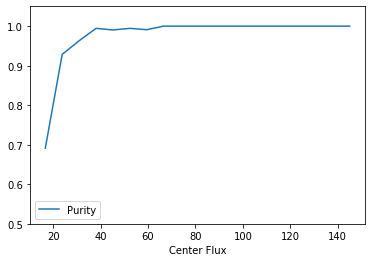

In [6]:
test_centers = CenterFlux(X_test, md_test)
hist, bins = np.histogram(test_centers, bins=25)
bin_centers = []
purity, completeness = [], []
for i,x in enumerate(bins[:-1]):
    bin_centers.append((bins[i] + bins[i+1])/2)
    centers = test_centers[np.where((test_centers > bins[i]) & (test_centers <= bins[i+1]))[0]]
    md_centers = md_test.loc[np.where((test_centers > bins[i]) & (test_centers <= bins[i+1]))[0]]
    tp = np.sum((centers > center_thres) & ((md_centers.ACTION != 'DarkSpotInTemplateCenter') & (md_centers.ACTION != 'NoisyTemplate')))
    fn = np.sum((centers < center_thres) & ((md_centers.ACTION != 'DarkSpotInTemplateCenter') & (md_centers.ACTION != 'NoisyTemplate')))
    fp = np.sum((centers > center_thres) & ((md_centers.ACTION == 'DarkSpotInTemplateCenter') | (md_centers.ACTION == 'NoisyTemplate')))
    purity.append(tp / (tp + fp))
    completeness.append(tp / (tp + fn))
plt.plot(bin_centers, purity, label='Purity')
plt.xlabel('Center Flux')
plt.legend()
plt.ylim(0.5,1.05)

In [7]:
centers = CenterFlux(X_test, md_test)

tp = np.sum((centers > center_thres) & ((md_test.ACTION != 'DarkSpotInTemplateCenter') & (md_test.ACTION != 'NoisyTemplate')))
fn = np.sum((centers < center_thres) & ((md_test.ACTION != 'DarkSpotInTemplateCenter') & (md_test.ACTION != 'NoisyTemplate')))
fp = np.sum((centers > center_thres) & ((md_test.ACTION == 'DarkSpotInTemplateCenter') | (md_test.ACTION == 'NoisyTemplate')))
center_completeness = (tp / (tp + fn))
center_purity = tp / (tp + fp)

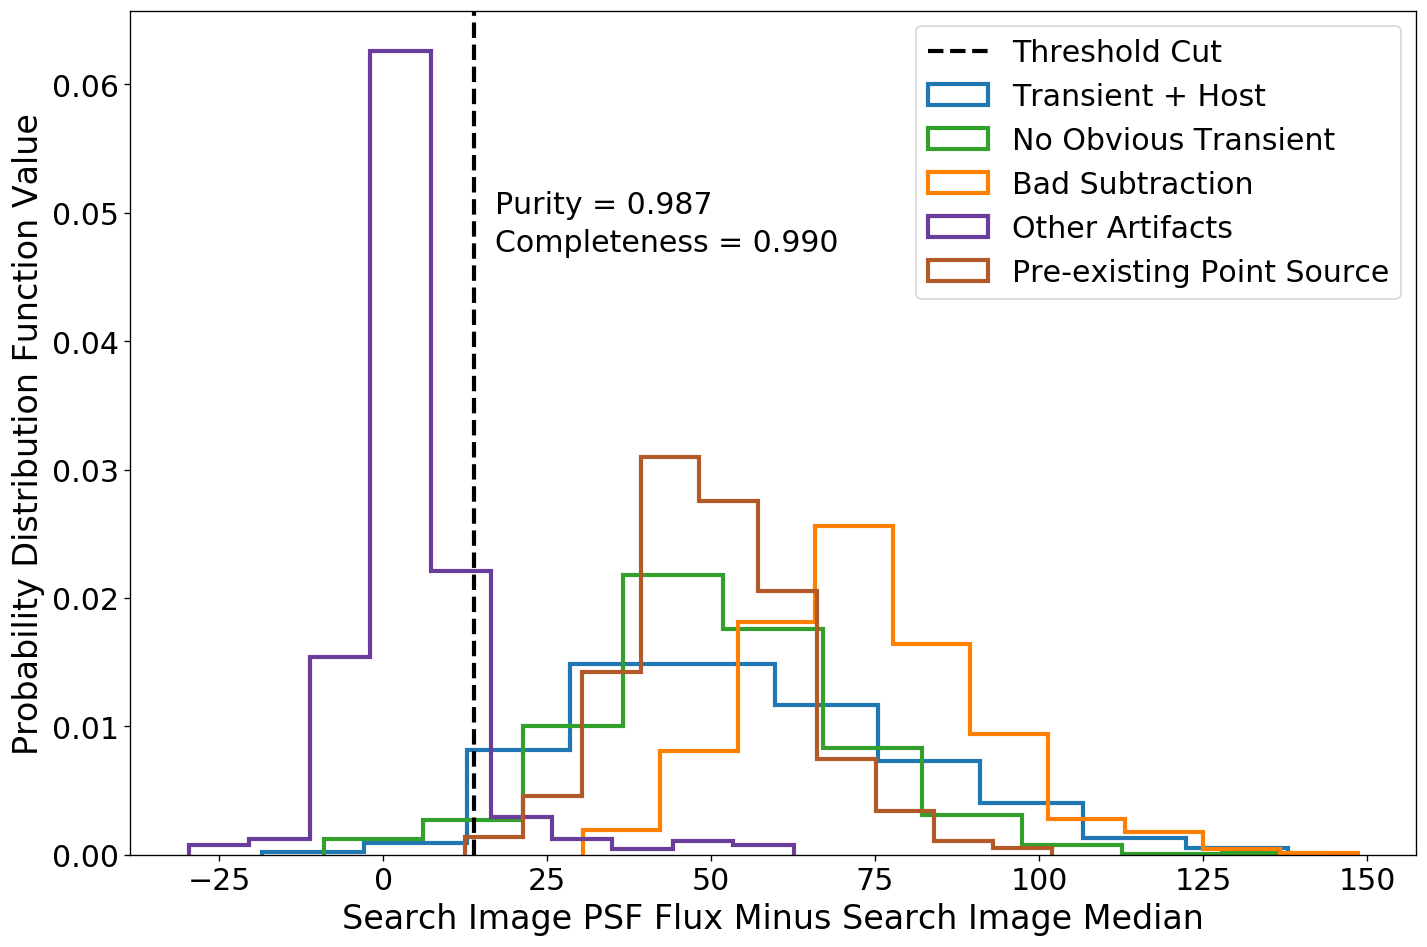

In [8]:
class0_centers = CenterFlux(images_0,md_0)
class1_centers = CenterFlux(images_1,md_1)
class3_centers = CenterFlux(images_3,md_3)
class4_centers = CenterFlux(images_4,md_4)
class5_centers = CenterFlux(images_5,md_5)
class6_centers = CenterFlux(images_6,md_6)

plt.figure(figsize=(12,8), dpi=120)
plt.hist(class0_centers,histtype='step',label='Transient + Host',color='#1F78B4',linewidth=2.5,density=True)
plt.hist(class1_centers,histtype='step',label='No Obvious Transient',color='#33A02C',linewidth=2.5,density=True)
plt.hist(class3_centers,histtype='step',label='Bad Subtraction',color='#FF7F00',linewidth=2.5,density=True)
plt.hist(np.concatenate((class4_centers,class5_centers)),histtype='step',label='Other Artifacts',color='#6A3D9A',linewidth=2.5,density=True)
#plt.hist(class5_centers,histtype='step',label='Noisy Template', linewidth=2, density=True)
plt.hist(class6_centers,histtype='step',label='Pre-existing Point Source',color='#B15928',linewidth=2.5,density=True)
plt.axvline(x=center_thres, linestyle='--',color='black',linewidth=2.5,label='Threshold Cut')
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Search Image PSF Flux Minus Search Image Median',fontsize=20)
plt.ylabel('Probability Distribution Function Value',fontsize=20)
plt.annotate('Purity = %.3f' %center_purity,xy=(17,0.05),fontsize=18)
plt.annotate('Completeness = %.3f' %center_completeness,xy=(17,0.047),fontsize=18)
plt.tight_layout()
plt.savefig('CenterDifference_histogram.pdf')
plt.show()

/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


(0.8, 1.05)

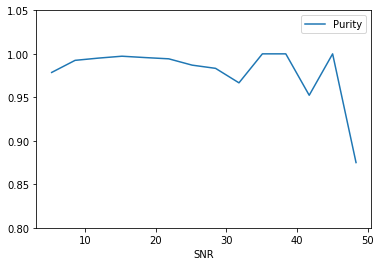

In [9]:
test_snr = SNR(md_test.loc[np.where(test_centers > center_thres)[0]])
md_test_centers = md_test.loc[np.where(test_centers > center_thres)[0]].reset_index(drop=True)
md_test_snr = md_test_centers.loc[np.where(test_snr < 50)[0]].reset_index(drop=True)
test_snr_final = test_snr[np.where(test_snr < 50)[0]]
hist, bins = np.histogram(test_snr_final, bins=15)
bin_snr = []
purity, completeness = [], []
for i,x in enumerate(bins[:-1]):
    bin_snr.append((bins[i] + bins[i+1])/2)
    snrs = test_snr_final[np.where((test_snr_final > bins[i]) & (test_snr_final <= bins[i+1]))[0]]
    md_snr = md_test_snr.loc[np.where((test_snr_final > bins[i]) & (test_snr_final <= bins[i+1]))[0]]
    tp = np.sum((snrs > snr_thres) & ((md_snr.ACTION != 'DarkSpotInTemplateCenter') & (md_snr.ACTION != 'NoisyTemplate')))
    fn = np.sum((snrs < snr_thres) & ((md_snr.ACTION != 'DarkSpotInTemplateCenter') & (md_snr.ACTION != 'NoisyTemplate')))
    fp = np.sum((snrs > snr_thres) & ((md_snr.ACTION == 'DarkSpotInTemplateCenter') | (md_snr.ACTION == 'NoisyTemplate')))
    purity.append(tp / (tp + fp))
    completeness.append(tp / (tp + fn))
plt.plot(bin_snr, purity, label='Purity')
plt.xlabel('SNR')
plt.legend()
plt.ylim(0.8,1.05)

In [10]:
test_snr = SNR(md_test.loc[np.where(centers > center_thres)[0]])
md_test_centers = md_test.loc[np.where(centers > center_thres)[0]].reset_index(drop=True)
tp = np.sum((test_snr > snr_thres) & ((md_test_centers.ACTION != 'DarkSpotInTemplate') & (md_test_centers.ACTION != 'NoisyTemplate')))
fn = np.sum((test_snr < snr_thres) & ((md_test_centers.ACTION != 'DarkSpotInTemplate') & (md_test_centers.ACTION != 'NoisyTemplate')))
fp = np.sum((test_snr > snr_thres) & ((md_test_centers.ACTION == 'DarkSpotInTemplate') | (md_test_centers.ACTION == 'NoisyTemplate')))
snr_purity = (tp / (tp + fp))
snr_completeness = (tp / (tp + fn))

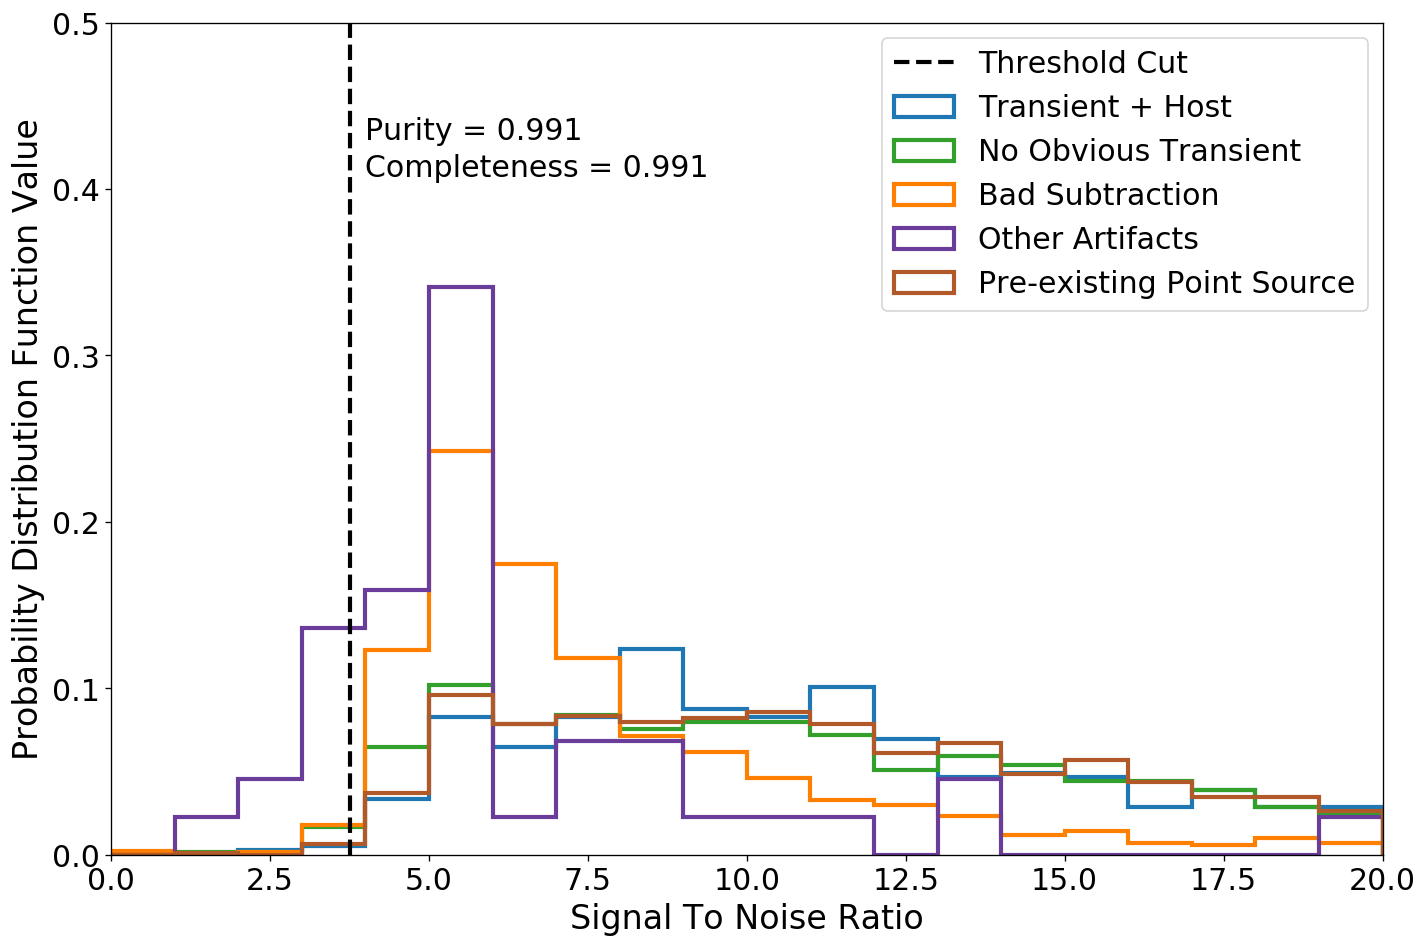

In [11]:
snr_0 = SNR(md_0.loc[np.where(class0_centers > center_thres)[0]])
snr_1 = SNR(md_1.loc[np.where(class1_centers > center_thres)[0]])
snr_3 = SNR(md_3.loc[np.where(class3_centers > center_thres)[0]])
snr_4 = SNR(md_4.loc[np.where(class4_centers > center_thres)[0]])
snr_5 = SNR(md_5.loc[np.where(class5_centers > center_thres)[0]])
snr_6 = SNR(md_6.loc[np.where(class6_centers > center_thres)[0]])

plt.figure(figsize=(12,8), dpi=120)
plt.hist(snr_0,histtype='step',label='Transient + Host',linewidth=2.5,color='#1F78B4',range=(0,20),bins=20,density=True)
plt.hist(snr_1,histtype='step',label='No Obvious Transient',linewidth=2.5,color='#33A02C',range=(0,20),bins=20,density=True)
plt.hist(snr_3,histtype='step',label='Bad Subtraction',linewidth=2.5,color='#FF7F00',range=(0,20), bins=20,density=True)
plt.hist(np.concatenate((snr_4,snr_5)),histtype='step',label='Other Artifacts',linewidth=2.5,color='#6A3D9A',range=(0,20),bins=20,density=True)
plt.hist(snr_6,histtype='step',label='Pre-existing Point Source',linewidth=2.5,color='#B15928',range=(0,20),bins=20,density=True)
plt.axvline(x=snr_thres,linestyle='--',linewidth=2.5,color='black',label='Threshold Cut')
plt.legend(fontsize=18)
plt.xlim(0,20)
plt.ylim(0,0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Signal To Noise Ratio',fontsize=20)
plt.ylabel('Probability Distribution Function Value',fontsize=20)
plt.annotate('Purity = %.3f' %snr_purity,xy=(4,0.43),fontsize=18)
plt.annotate('Completeness = %.3f' %snr_completeness,xy=(4,0.408),fontsize=18)
plt.tight_layout()
plt.savefig('SNR_histogram.pdf')
plt.show()

In [29]:
X_test = np.concatenate((X_test0,images_1,X_test3,images_4,images_5,images_6))
y_test = np.concatenate((y_test0,y_1,y_test3,y_4,y_5,y_6))
md_test = pd.concat([mdtest0,md_1,mdtest3,md_4,md_5,md_6], ignore_index=True)

In [24]:
len(md_test.loc[np.where(md_test['PHOTPROB'] > 0.7)[0]])

1836

In [25]:
md_test.loc[np.where(md_test['PHOTPROB'] > 0.7)[0]].PHOTPROB

0       0.928
1       0.773
2       0.863
3       0.980
4       0.910
        ...  
4082    0.910
4083    0.880
4084    0.860
4085    0.930
4086    0.903
Name: PHOTPROB, Length: 1836, dtype: float64

In [26]:
md_test.keys()

Index(['MJD', 'FLT', 'FLUXCAL', 'FLUXCALERR', 'PHOTFLAG', 'PHOTPROB', 'ZPFLUX',
       'PSF', 'SKYSIG', 'SKYSIG_T', 'GAIN', 'XPIX', 'YPIX', 'EXPNUM', 'CCDNUM',
       'SNID', 'ACTION', 'COMMENT', 'TIME', 'USER', 'OBJID_COPY', 'BATCH',
       'OBJID', 'Unnamed: 0'],
      dtype='object')

In [27]:
len(X_test)

4087

In [30]:
print(len(md_test.loc[md_test['ACTION'] == 'Good']))
print(len(md_test.loc[md_test['ACTION'] == 'Marginal']))
print(len(md_test.loc[md_test['ACTION'] == 'BadSubtraction']))
print(len(md_test.loc[md_test['ACTION'] == 'NoisyTemplate']))
print(len(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter']))
print(len(md_test.loc[md_test['ACTION'] == 'PsfInTemplate']))

test_centers = CenterFlux(X_test, md_test)

test_snr = SNR(md_test.loc[np.where(test_centers > center_thres)[0]])

md_test_centers = md_test.loc[np.where(test_centers > center_thres)[0]].reset_index(drop=True)

md_test_filtered = md_test_centers.loc[np.where(test_snr > snr_thres)[0]]

test_remaining_indices = md_test[['OBJID']].merge(md_test_filtered, on='OBJID', how='inner', right_index=True).index

X_test = X_test[test_remaining_indices]
y_test = y_test[test_remaining_indices]
md_test = md_test_filtered.reset_index(drop=True)

print(len(md_test.loc[md_test['ACTION'] == 'Good']))
print(len(md_test.loc[md_test['ACTION'] == 'Marginal']))
print(len(md_test.loc[md_test['ACTION'] == 'BadSubtraction']))
print(len(md_test.loc[md_test['ACTION'] == 'NoisyTemplate']))
print(len(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter']))
print(len(md_test.loc[md_test['ACTION'] == 'PsfInTemplate']))

X_test, y_test, md_test = CatalogMatching(X_test, y_test, md_test)

print(len(md_test.loc[md_test['ACTION'] == 'Good']))
print(len(md_test.loc[md_test['ACTION'] == 'Marginal']))
print(len(md_test.loc[md_test['ACTION'] == 'BadSubtraction']))
print(len(md_test.loc[md_test['ACTION'] == 'NoisyTemplate']))
print(len(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter']))
print(len(md_test.loc[md_test['ACTION'] == 'PsfInTemplate']))

385
921
1000
368
363
1050
375
884
994
36
11
1045
375
825
980
36
11
857


In [17]:
test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]
md_test = md_test.iloc[test_idx].reset_index(drop=True)

In [18]:
model1 = CNN()
model1.load_state_dict(torch.load('/home/ashandonay/cosmology/model1.pt'))
model1.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=107648, out_features=328, bias=True)
  (fc2): Linear(in_features=328, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=2, bias=True)
)

In [19]:
test_dataset_full = ArtifactDataset(X_test, y_test, md_test, transform=ToTensor())

In [20]:
validation_probs1 = torch.max(model1(test_dataset_full[0:1000]['image']), 1)[1].data.numpy()

In [21]:
validation_probs2 = torch.max(model1(test_dataset_full[1000:2000]['image']), 1)[1].data.numpy()

In [22]:
validation_probs3 = torch.max(model1(test_dataset_full[2000:3500]['image']), 1)[1].data.numpy()

In [23]:
validation_probs = np.concatenate((validation_probs1, validation_probs2, validation_probs3))

pred_class0 = validation_probs[md_test.loc[md_test['ACTION'] == 'Good'].index]
pred_class1 = validation_probs[md_test.loc[md_test['ACTION'] == 'Marginal'].index]
pred_class3 = validation_probs[md_test.loc[md_test['ACTION'] == 'BadSubtraction'].index]
pred_class4 = validation_probs[(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter'].index) | 
                                         (md_test.loc[md_test['ACTION'] == 'NoisyTemplate'].index)]
pred_class6 = validation_probs[md_test.loc[md_test['ACTION'] == 'PsfInTemplate'].index]

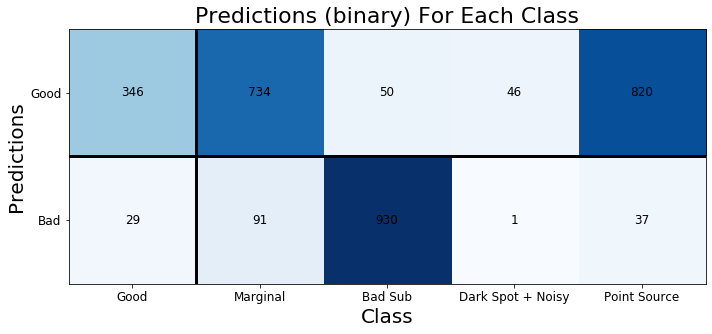

In [24]:
pred0_class0 = (pred_class0 == 0).sum()
pred1_class0 = (pred_class0 == 1).sum()

pred0_class1 = (pred_class1 == 0).sum()
pred1_class1 = (pred_class1 == 1).sum()

pred0_class3 = (pred_class3 == 0).sum()
pred1_class3 = (pred_class3 == 1).sum()

pred0_class4 = (pred_class4 == 0).sum()
pred1_class4 = (pred_class4 == 1).sum()

pred0_class6 = (pred_class6 == 0).sum()
pred1_class6 = (pred_class6 == 1).sum()

cm = np.array([[pred0_class0,pred0_class1,pred0_class3,pred0_class4,pred0_class6],
                [pred1_class0,pred1_class1,pred1_class3,pred1_class4,pred1_class6]])

classes = ['Good','Marginal','Bad Sub','Dark Spot + Noisy','Point Source']
labels = ['Good','Bad']

fig, ax = plt.subplots(1,1,figsize=(10, 8))

ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Predictions", fontsize=20)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.axhline(0.5, linestyle='-', color='k', linewidth='3')
ax.axvline(0.5, linestyle='-', color='k', linewidth='3')

for i in range(len(labels)):
    for j in range(len(classes)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", fontsize=12)

ax.set_title('Predictions (binary) For Each Class', fontsize=22)
fig.tight_layout()

In [25]:
validation_probs1 = model1(test_dataset_full[0:1000]['image']).data.numpy()

In [26]:
validation_probs2 = model1(test_dataset_full[1000:2000]['image']).data.numpy()

In [27]:
validation_probs3 = model1(test_dataset_full[2000:3500]['image']).data.numpy()

In [28]:
validation_probs = np.concatenate((validation_probs1, validation_probs2, validation_probs3))

validation_probs -= validation_probs.min()
validation_probs /= validation_probs.max()
validation_probs /= np.sum(validation_probs, axis=1)[:,np.newaxis]

pred_class0 = validation_probs[md_test.loc[md_test['ACTION'] == 'Good'].index]
pred_class1 = validation_probs[md_test.loc[md_test['ACTION'] == 'Marginal'].index]
pred_class3 = validation_probs[md_test.loc[md_test['ACTION'] == 'BadSubtraction'].index]
pred_class4 = validation_probs[(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter'].index) | 
                                         (md_test.loc[md_test['ACTION'] == 'NoisyTemplate'].index)]
pred_class6 = validation_probs[md_test.loc[md_test['ACTION'] == 'PsfInTemplate'].index]

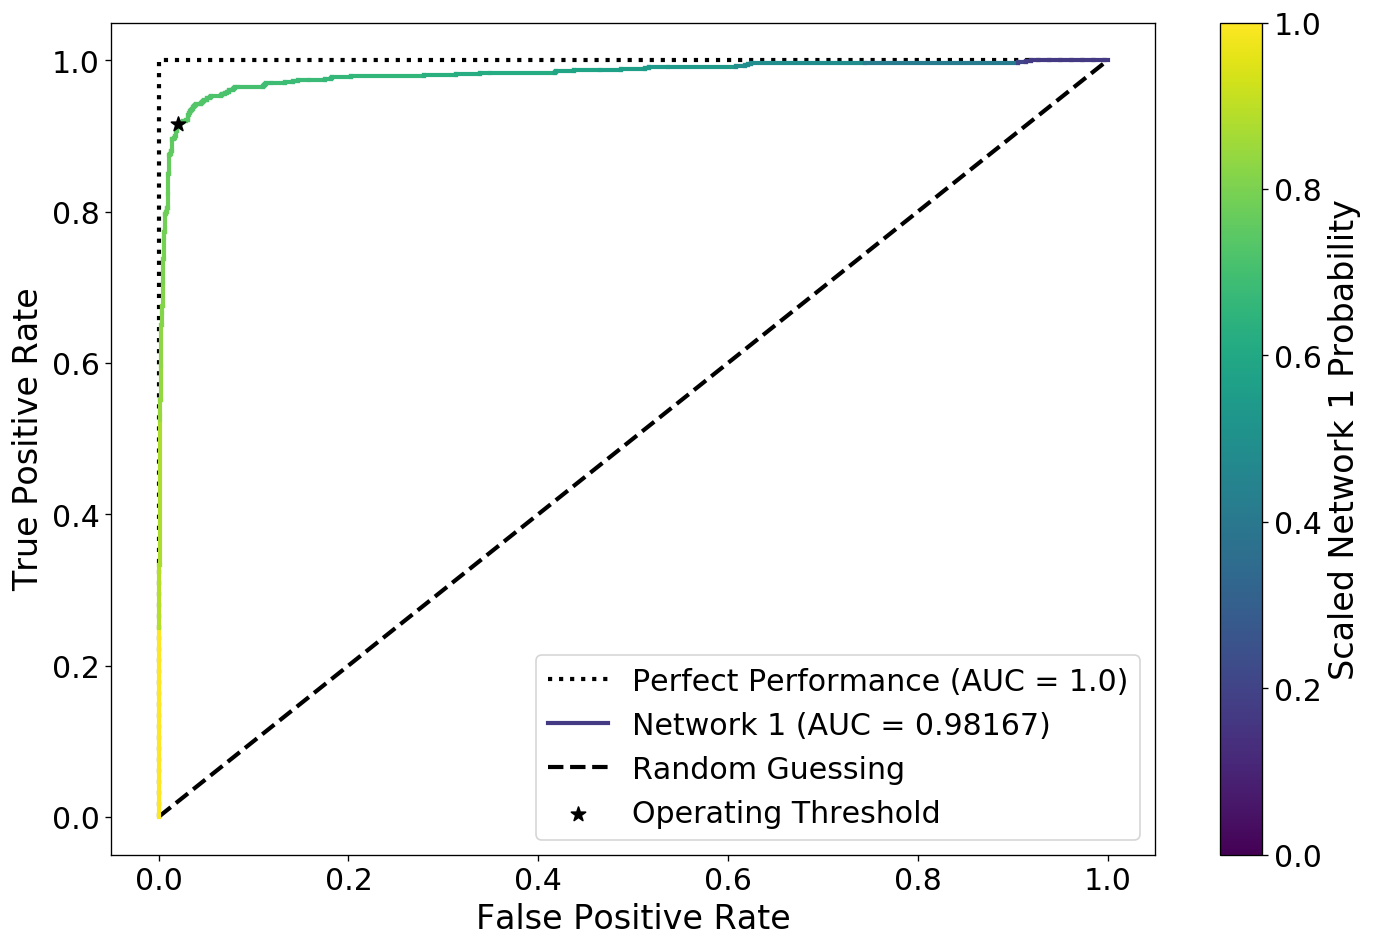

0.50843436

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve

precision, recall, f1_thresholds = precision_recall_curve(test_dataset_full[0:len(test_dataset_full)]['label'], validation_probs[:,1])
f1_scores = 2*recall*precision/(recall+precision)
operating_threshold = f1_thresholds[np.argmax(f1_scores)]

cm = plt.get_cmap('viridis')
lw = 2.5

plt.figure(figsize=(12,8), dpi=120)

fpr, tpr, thresholds = roc_curve(test_dataset_full[0:len(test_dataset_full)]['label'], validation_probs[:,1])

scaler = MinMaxScaler()
scaled_thresholds = scaler.fit_transform(np.where(thresholds < 0.3, 0.3, np.where(thresholds > 0.58, 0.58, thresholds)).reshape(-1,1)).reshape(len(thresholds),)

roc_auc = roc_auc_score(test_dataset_full[0:len(test_dataset_full)]['label'], validation_probs[:,1])
garb = plt.scatter(fpr + 80, tpr + 80, c=scaled_thresholds)
plt.plot([0.0,0.0,1.0], [0.0,1.0,1.0], label='Perfect Performance (AUC = 1.0)', ls=':', zorder=10, lw=lw,c='black')
for i in range(len(fpr) -1):
    if i > len(fpr) - 3:
        plt.plot([fpr[i], fpr[i+1]], [tpr[i], tpr[i+1]], c=cm(scaled_thresholds[i]), lw=lw, zorder=20, label='Network 1 (AUC = %.5f)' %roc_auc)
    else:
        plt.plot([fpr[i], fpr[i+1]], [tpr[i], tpr[i+1]], c=cm(scaled_thresholds[i]), lw=lw, zorder=20, label=None)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--', label='Random Guessing',c='black')
cbar = plt.colorbar(garb)
cbar.set_label('Scaled Network 1 Probability', size=20)
cbar.ax.tick_params(labelsize=18)
plt.scatter(fpr[np.argmin(np.abs(thresholds - operating_threshold))], tpr[np.argmin(np.abs(thresholds - operating_threshold))],marker='*', s=80, c='black', zorder=200, label='Operating Threshold')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.tight_layout()
plt.savefig('ROC_curve.pdf')
plt.show()
operating_threshold

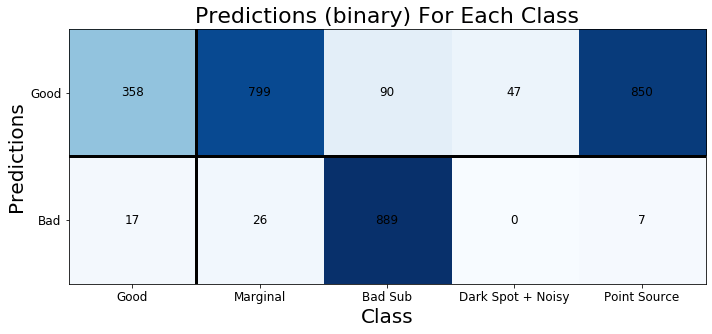

In [30]:
pred0_class0 = (pred_class0[:,1] < operating_threshold).sum()
pred1_class0 = (pred_class0[:,1] > operating_threshold).sum()

pred0_class1 = (pred_class1[:,1] < operating_threshold).sum()
pred1_class1 = (pred_class1[:,1] > operating_threshold).sum()

pred0_class3 = (pred_class3[:,1] < operating_threshold).sum()
pred1_class3 = (pred_class3[:,1] > operating_threshold).sum()

pred0_class4 = (pred_class4[:,1] < operating_threshold).sum()
pred1_class4 = (pred_class4[:,1] > operating_threshold).sum()

pred0_class6 = (pred_class6[:,1] < operating_threshold).sum()
pred1_class6 = (pred_class6[:,1] > operating_threshold).sum()

cm = np.array([[pred0_class0,pred0_class1,pred0_class3,pred0_class4,pred0_class6],
                [pred1_class0,pred1_class1,pred1_class3,pred1_class4,pred1_class6]])

classes = ['Good','Marginal','Bad Sub','Dark Spot + Noisy','Point Source']
labels = ['Good','Bad']

fig, ax = plt.subplots(1,1,figsize=(10, 8))

ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Predictions", fontsize=20)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.axhline(0.5, linestyle='-', color='k', linewidth='3')
ax.axvline(0.5, linestyle='-', color='k', linewidth='3')

for i in range(len(labels)):
    for j in range(len(classes)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", fontsize=12)

ax.set_title('Predictions (binary) For Each Class', fontsize=22)
fig.tight_layout()

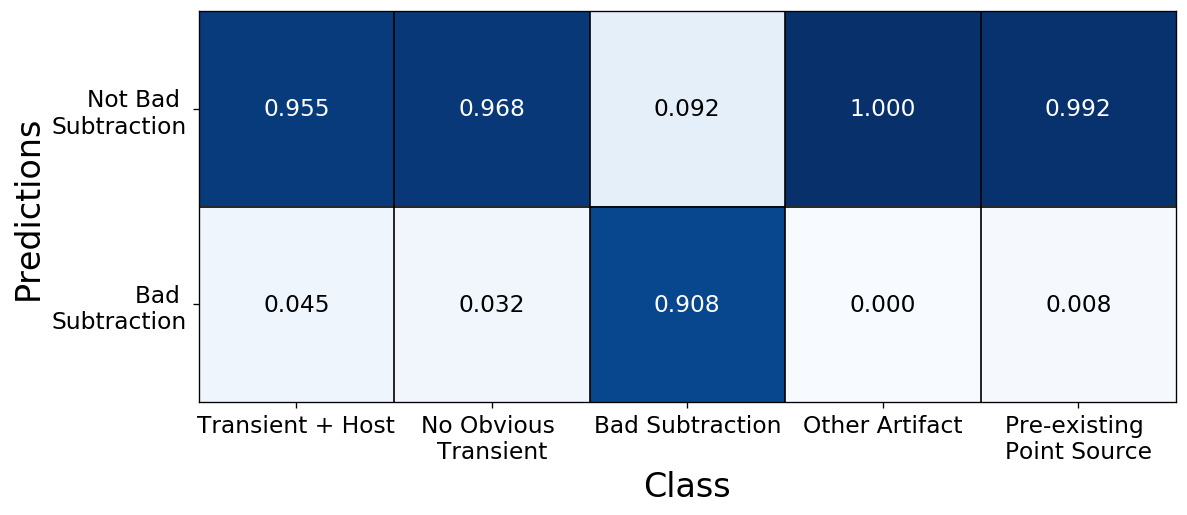

In [31]:
pred0_class0 = (pred_class0[:,1] < operating_threshold).sum()
pred1_class0 = (pred_class0[:,1] > operating_threshold).sum()

pred0_class0_per = pred0_class0/(pred0_class0 + pred1_class0)
pred1_class0_per = pred1_class0/(pred0_class0 + pred1_class0)

pred0_class1 = (pred_class1[:,1] < operating_threshold).sum()
pred1_class1 = (pred_class1[:,1] > operating_threshold).sum()

pred0_class1_per = pred0_class1/(pred0_class1 + pred1_class1)
pred1_class1_per = pred1_class1/(pred0_class1 + pred1_class1)

pred0_class3 = (pred_class3[:,1] < operating_threshold).sum()
pred1_class3 = (pred_class3[:,1] > operating_threshold).sum()

pred0_class3_per = pred0_class3/(pred0_class3 + pred1_class3)
pred1_class3_per = pred1_class3/(pred0_class3 + pred1_class3)

pred0_class4 = (pred_class4[:,1] < operating_threshold).sum()
pred1_class4 = (pred_class4[:,1] > operating_threshold).sum()

pred0_class4_per = pred0_class4/(pred0_class4 + pred1_class4)
pred1_class4_per = pred1_class4/(pred0_class4 + pred1_class4)

pred0_class6 = (pred_class6[:,1] < operating_threshold).sum()
pred1_class6 = (pred_class6[:,1] > operating_threshold).sum()

pred0_class6_per = pred0_class6/(pred0_class6 + pred1_class6)
pred1_class6_per = pred1_class6/(pred0_class6 + pred1_class6)

cm = np.array([[pred0_class0_per,pred0_class1_per,pred0_class3_per,pred0_class4_per,pred0_class6_per],
                [pred1_class0_per,pred1_class1_per,pred1_class3_per,pred1_class4_per,pred1_class6_per]])

classes = ['Transient + Host','No Obvious \nTransient','Bad Subtraction','Other Artifact','Pre-existing \nPoint Source']
labels = ['Not Bad \nSubtraction','Bad \nSubtraction']

fig, ax = plt.subplots(1,1,figsize=(10, 8), dpi=120)

ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Predictions", fontsize=20)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(classes, fontsize=14)
ax.set_yticklabels(labels, fontsize=14)
ax.axhline(0.5, linestyle='-', color='k', linewidth='1')
ax.axvline(0.5, linestyle='-', color='k', linewidth='1')
ax.axvline(1.5, linestyle='-', color='k', linewidth='1')
ax.axvline(2.5, linestyle='-', color='k', linewidth='1')
ax.axvline(3.5, linestyle='-', color='k', linewidth='1')

for i in range(len(labels)):
    for j in range(len(classes)):
        text = ax.text(j, i, format(cm[i, j],'.3f'),
                       ha="center", va="center", fontsize=14,
                       color="white" if cm[i, j] > 0.5 else "black")

#ax.set_title('Predictions (binary) For Each Class', fontsize=22)
fig.tight_layout()
plt.savefig('FirstNetwork_Results.pdf')

In [3]:
model2 = CNN()
model2.load_state_dict(torch.load('/home/ashandonay/cosmology/model2.pt'))
model2.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=107648, out_features=328, bias=True)
  (fc2): Linear(in_features=328, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=2, bias=True)
)

In [4]:
X_trainsims, X_testsims, y_trainsims, y_testsims, mdtrainsims, mdtestsims = TrainTest('passed/Class_sims_images.h5','passed/Class_sims_metadata.csv',200,200,0)
images_sims = np.concatenate((X_trainsims, X_testsims))
y_sims = np.concatenate((y_trainsims, y_testsims))
md_sims = pd.concat([mdtrainsims, mdtestsims])

X_train0, X_test0, y_train0, y_test0, mdtrain0, mdtest0 = TrainTest('passed/Class_0_images.h5','passed/Class_0_metadata.csv',200,400,0)
images_0 = np.concatenate((X_train0, X_test0))
y_0 = np.concatenate((y_train0, y_test0))
md_0 = pd.concat([mdtrain0, mdtest0])

X_train1, X_test1, y_train1, y_test1, mdtrain1, mdtest1 = TrainTest('passed/Class_1_images.h5','passed/Class_1_metadata.csv',250,400,1)
images_1 = np.concatenate((X_train1, X_test1))
y_1 = np.concatenate((y_train1, y_test1))
md_1 = pd.concat([mdtrain1, mdtest1])

X_train3, X_test3, y_train3, y_test3, mdtrain3, mdtest3 = TrainTest('passed/Class_3_images.h5','passed/Class_3_metadata.csv',70,100,1)
images_3 = np.concatenate((X_train3, X_test3))
md_3 = pd.concat([mdtrain3, mdtest3])

X_train4, X_test4, y_train4, y_test4, mdtrain4, mdtest4 = TrainTest('passed/Class_4_images.h5','passed/Class_4_metadata.csv',30,40,1)
images_4 = np.concatenate((X_train4, X_test4))
y_4 = np.concatenate((y_train4, y_test4))
md_4 = pd.concat([mdtrain4, mdtest4])


X_train6, X_test6, y_train6, y_test6, mdtrain6, mdtest6 = TrainTest('passed/Class_6_images.h5','passed/Class_6_metadata.csv',250,400,1)
images_6 = np.concatenate((X_train6, X_test6))
y_6 = np.concatenate((y_train6, y_test6))
md_6 = pd.concat([mdtrain6, mdtest6])

In [5]:
X_test = np.concatenate((X_test0,X_test1,X_test3,X_test4,X_test6))
y_test = np.concatenate((y_test0,y_test1,y_test3,y_test4,y_test6))
md_test = pd.concat([mdtest0,mdtest1,mdtest3,mdtest4,mdtest6], ignore_index=True)

In [6]:
print(len(md_test.loc[md_test['ACTION'] == 'Good']))
print(len(md_test.loc[md_test['ACTION'] == 'Marginal']))
print(len(md_test.loc[md_test['ACTION'] == 'BadSubtraction']))
print(len(md_test.loc[md_test['ACTION'] == 'NoisyTemplate']))
print(len(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter']))
print(len(md_test.loc[md_test['ACTION'] == 'PsfInTemplate']))

158
150
20
7
3
150


In [7]:
test_idx = np.arange(X_test.shape[0])
np.random.shuffle(test_idx)
X_test = X_test[test_idx]
y_test = y_test[test_idx]
md_test = md_test.iloc[test_idx].reset_index(drop=True)

In [8]:
test_dataset_full = ArtifactDataset(X_test, y_test, md_test, transform=ToTensor())

In [9]:
validation_probs = torch.max(model2(test_dataset_full[0:len(test_dataset_full)]['image']), 1)[1].data.numpy()

In [10]:
pred_class0 = validation_probs[md_test.loc[md_test['ACTION'] == 'Good'].index]
pred_class1 = validation_probs[md_test.loc[md_test['ACTION'] == 'Marginal'].index]
pred_class3 = validation_probs[md_test.loc[md_test['ACTION'] == 'BadSubtraction'].index]
pred_class4 = validation_probs[(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter'].index) | 
                                         (md_test.loc[md_test['ACTION'] == 'NoisyTemplate'].index)]
pred_class6 = validation_probs[md_test.loc[md_test['ACTION'] == 'PsfInTemplate'].index]

In [11]:
pred0_class0 = (pred_class0 == 0).sum()
pred1_class0 = (pred_class0 == 1).sum()

pred0_class1 = (pred_class1 == 0).sum()
pred1_class1 = (pred_class1 == 1).sum()

pred0_class3 = (pred_class3 == 0).sum()
pred1_class3 = (pred_class3 == 1).sum()

pred0_class4 = (pred_class4 == 0).sum()
pred1_class4 = (pred_class4 == 1).sum()

pred0_class6 = (pred_class6 == 0).sum()
pred1_class6 = (pred_class6 == 1).sum()

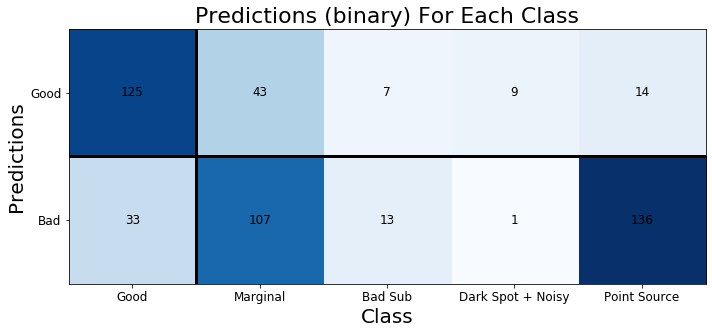

In [12]:
cm = np.array([[pred0_class0,pred0_class1,pred0_class3,pred0_class4,pred0_class6],
                [pred1_class0,pred1_class1,pred1_class3,pred1_class4,pred1_class6]])

classes = ['Good','Marginal','Bad Sub','Dark Spot + Noisy','Point Source']
labels = ['Good','Bad']

fig, ax = plt.subplots(1,1,figsize=(10, 8))

ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Predictions", fontsize=20)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)
ax.axhline(0.5, linestyle='-', color='k', linewidth='3')
ax.axvline(0.5, linestyle='-', color='k', linewidth='3')

for i in range(len(labels)):
    for j in range(len(classes)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", fontsize=12)

ax.set_title('Predictions (binary) For Each Class', fontsize=22)
fig.tight_layout()

In [12]:
validation_probs = model2(test_dataset_full[0:len(test_dataset_full)]['image']).data.numpy()

In [13]:
validation_probs -= validation_probs.min()
validation_probs /= validation_probs.max()
validation_probs /= np.sum(validation_probs, axis=1)[:,np.newaxis]

In [45]:
len(np.where(validation_probs[:,0] > 0.5)[0])

198

In [14]:
prob_class0 = validation_probs[md_test.loc[md_test['ACTION'] == 'Good'].index]
prob_class1 = validation_probs[md_test.loc[md_test['ACTION'] == 'Marginal'].index]
prob_class3 = validation_probs[md_test.loc[md_test['ACTION'] == 'BadSubtraction'].index]
prob_class4 = validation_probs[(md_test.loc[md_test['ACTION'] == 'DarkSpotInTemplateCenter'].index) | 
                                         (md_test.loc[md_test['ACTION'] == 'NoisyTemplate'].index)]
prob_class6 = validation_probs[md_test.loc[md_test['ACTION'] == 'PsfInTemplate'].index]

In [15]:
validation_probs = torch.max(model2(test_dataset_full[0:len(test_dataset_full)]['image']), 1)[1].data.numpy()

In [33]:
mags = 27.5 - 2.5 * np.log10(np.where(md_test["FLUXCAL"].values < 1.0, 1.0, md_test["FLUXCAL"].values))
indices = []
for x in range(8):
    width = (max(mags) - min(mags))/8
    lower = min(mags) + x*width
    upper = min(mags) + (x+1)*width
    indices.append(np.where((mags >= lower) & (mags < upper))[0])

-0.08419425221408833


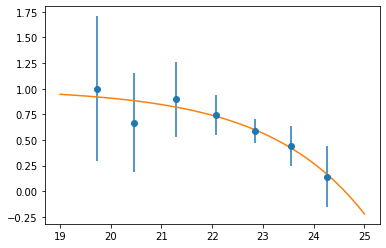

In [39]:
purity = []
mean_mag = []
purity_err = []
for i in range(1,8):
    tp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 0))
    fn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 0))
    fp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 1))
    tn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 1))
    numer = tp
    denom = tp + fp
    if fp == 0:
        purity_err.append(1/np.sqrt(tn))
    else:
        purity_err.append(numer / denom * np.sqrt(((1 + np.sqrt(numer)) / numer)**2 + ((1 + np.sqrt(denom)) / denom)**2))
    purity.append(tp / (tp + fp))
    mean_mag.append(np.mean(mags[indices[i]]))
    
purity = np.array(purity)
mean_mag = np.array(mean_mag)
purity_err = np.array(purity_err)

def purity_mag_func(x, a, b, c):
    return 1.0 - a * np.exp(b*x - c)
popt, pcov = curve_fit(purity_mag_func, mean_mag, purity, sigma=purity_err)
basis = np.linspace(19, 25, 100)
best_fit_purity = purity_mag_func(basis, *popt)
chi2 = np.sum((purity - purity_mag_func(mean_mag, *popt)) / purity_err)
print(chi2)
plt.figure()
plt.errorbar(mean_mag, purity, yerr=purity_err, fmt='o')
plt.plot(basis, best_fit_purity)
plt.show()
plt.close()

0.16155558603427816


/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


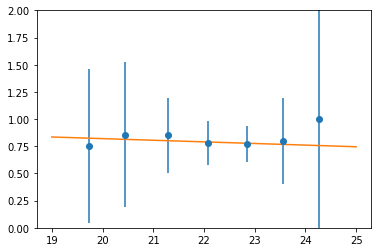

In [40]:
completeness = []
mean_mag = []
completeness_err = []
for i in range(1,8):
    tp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 0))
    fn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 0))
    fp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 1))
    tn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 1))
    numer = tp
    denom = tp + fn
    if fp == 0:
        completeness_err.append(1/np.sqrt(tn))
    else:
        completeness_err.append(numer / denom * np.sqrt(((1 + np.sqrt(numer)) / numer)**2 + ((1 + np.sqrt(denom)) / denom)**2))
    completeness.append(tp / (tp + fn))
    mean_mag.append(np.mean(mags[indices[i]]))
    
completeness = np.array(completeness)
mean_mag = np.array(mean_mag)
completeness_err = np.array(completeness_err)

def poly4(x, a0, a1, a2, a3, a4):
    return a0 + a1 * x 
popt, pcov = curve_fit(poly4, mean_mag, completeness, sigma=completeness_err)
basis = np.linspace(19, 25, 100)
best_fit_completeness = poly4(basis, *popt)
chi2 = np.sum((completeness - poly4(mean_mag, *popt)) / completeness_err)
print(chi2)
plt.figure()
plt.errorbar(mean_mag, completeness, yerr=completeness_err, fmt='o')
plt.plot(basis, best_fit_completeness)
plt.ylim(0,2)
plt.show()
plt.close()

0.6559544040025582


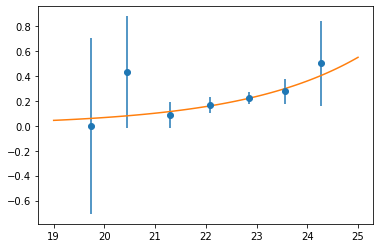

In [41]:
fpr = []
fpr_err = []
mean_mag = []
for i in range(1,8):
    tp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 0))
    fn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 0))
    fp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 1))
    tn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 1))
    numer = fp
    denom = fp + tn
    if fp == 0:
        fpr_err.append(1/np.sqrt(tn))
    else:
        fpr_err.append(numer / denom * np.sqrt(((1 + np.sqrt(numer)) / numer)**2 + ((1 + np.sqrt(denom)) / denom)**2))
    fpr.append(fp / (fp + tn))
    mean_mag.append(np.mean(mags[indices[i]]))
    
mean_mag = np.array(mean_mag)
fpr = np.array(fpr)
fpr_err = np.array(fpr_err)

def fpr_mag_func(x, a, b, c):
    return a * np.exp(b*x - c)
popt, pcov = curve_fit(fpr_mag_func, mean_mag, fpr, sigma=fpr_err)
basis = np.linspace(19, 25, 100)
best_fit_fpr = fpr_mag_func(basis, *popt)
chi2 = np.sum((fpr - fpr_mag_func(mean_mag, *popt)) / fpr_err)
print(chi2)
plt.figure()
plt.errorbar(mean_mag, fpr, yerr=fpr_err, fmt='o')
plt.plot(basis, best_fit_fpr)
plt.show()
plt.close()

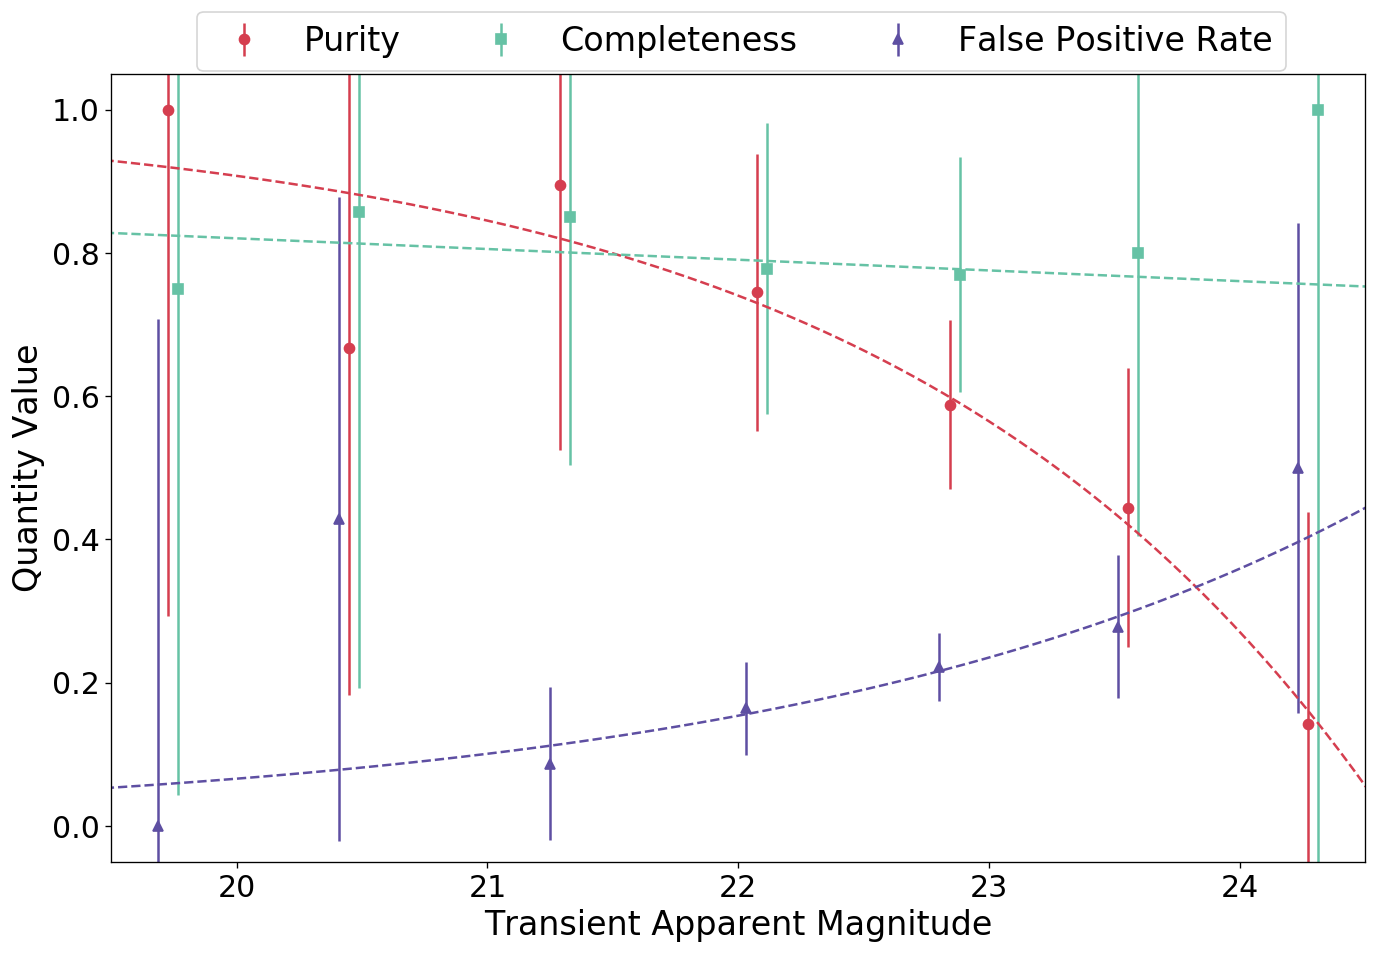

In [47]:
plt.figure(figsize=(12,8), dpi=120)

plt.errorbar(mean_mag, purity, yerr=purity_err, fmt='o',c='#d53e4f',label='Purity')
plt.plot(basis, best_fit_purity,c='#d53e4f',linestyle='--')

plt.errorbar(mean_mag+0.04, completeness, yerr=completeness_err, fmt='s',c='#66c2a5',label='Completeness')
plt.plot(basis, best_fit_completeness,c='#66c2a5',linestyle='--')

plt.errorbar(mean_mag-0.04, fpr, yerr=fpr_err, fmt='^',c='#5e4fa2',label='False Positive Rate')
plt.plot(basis, best_fit_fpr,c='#5e4fa2',linestyle='--')

plt.ylim(-.05,1.05)
plt.xlim(19.5,24.5)
plt.xlabel('Transient Apparent Magnitude',fontsize=20)
plt.ylabel('Quantity Value',fontsize=20)
plt.legend(ncol=3, loc='upper left', bbox_to_anchor=[0.055, 1.1],fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('mag.pdf')
plt.show()

In [48]:
snrs = SNR(md_test)
indices = []
for x in range(8):
    width = (45 - min(snrs))/8
    lower = min(snrs) + x*width
    upper = min(snrs) + (x+1)*width
    indices.append(np.where((snrs >= lower) & (snrs < upper))[0])

-0.3135724062835704


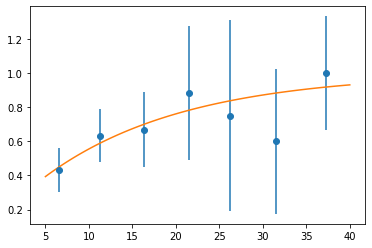

In [49]:
purity = []
mean_snr = []
purity_err = []
for i in range(0,7):
    tp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 0))
    fn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 0))
    fp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 1))
    tn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 1))
    numer = tp
    denom = tp + fp
    if fp == 0:
        purity_err.append(1/np.sqrt(tn))
    else:
        purity_err.append(numer / denom * np.sqrt(((1 + np.sqrt(numer)) / numer)**2 + ((1 + np.sqrt(denom)) / denom)**2))
    purity.append(tp / (tp + fp))
    mean_snr.append(np.mean(snrs[indices[i]]))
    
purity = np.array(purity)
mean_snr = np.array(mean_snr)
purity_err = np.array(purity_err)

def purity_snr_func(x, a, b, c):
    return 1.0 - a * np.exp(b*x - c)
popt, pcov = curve_fit(purity_snr_func, mean_snr, purity, sigma=purity_err)
basis = np.linspace(5, 40, 100)
best_fit_purity = purity_snr_func(basis, *popt)
chi2 = np.sum((purity - purity_snr_func(mean_snr, *popt)) / purity_err)
print(chi2)
plt.figure()
plt.errorbar(mean_snr, purity, yerr=purity_err, fmt='o')
plt.plot(basis, best_fit_purity)
plt.show()
plt.close()

0.1398241306732026


/home/ashandonay/miniconda3/envs/ml_astro/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


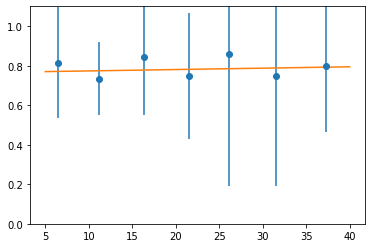

In [50]:
completeness = []
mean_snr = []
completeness_err = []
for i in range(0,7):
    tp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 0))
    fn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 0))
    fp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 1))
    tn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 1))
    numer = tp
    denom = tp + fn
    if fp == 0:
        completeness_err.append(1/np.sqrt(tn))
    else:
        completeness_err.append(numer / denom * np.sqrt(((1 + np.sqrt(numer)) / numer)**2 + ((1 + np.sqrt(denom)) / denom)**2))
    completeness.append(tp / (tp + fn))
    mean_snr.append(np.mean(snrs[indices[i]]))
    
completeness = np.array(completeness)
mean_snr = np.array(mean_snr)
completeness_err = np.array(completeness_err)

def poly4(x, a0, a1, a2, a3, a4):
    return a0 + a1 * x 
popt, pcov = curve_fit(poly4, mean_snr, completeness, sigma=completeness_err)
basis = np.linspace(5, 40, 100)
best_fit_completeness = poly4(basis, *popt)
chi2 = np.sum((completeness - poly4(mean_snr, *popt)) / completeness_err)
print(chi2)
plt.figure()
plt.errorbar(mean_snr, completeness, yerr=completeness_err, fmt='o')
plt.plot(basis, best_fit_completeness)
plt.ylim(0,1.1)
plt.show()
plt.close()

0.6766172761642849


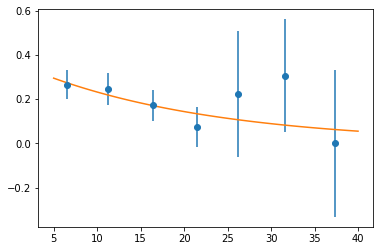

In [51]:
fpr = []
fpr_err = []
mean_snr = []
for i in range(0,7):
    tp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 0))
    fn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 0))
    fp = np.sum((validation_probs[indices[i]] == 0) & (y_test[indices[i]] == 1))
    tn = np.sum((validation_probs[indices[i]] == 1) & (y_test[indices[i]] == 1))
    numer = fp
    denom = fp + tn
    if fp == 0:
        fpr_err.append(1/np.sqrt(tn))
    else:
        fpr_err.append(numer / denom * np.sqrt(((1 + np.sqrt(numer)) / numer)**2 + ((1 + np.sqrt(denom)) / denom)**2))
    fpr.append(fp / (fp + tn))
    mean_snr.append(np.mean(snrs[indices[i]]))
    
mean_snr = np.array(mean_snr)
fpr = np.array(fpr)
fpr_err = np.array(fpr_err)

def fpr_snr_func(x, a, b, c):
    return a * np.exp(b*x - c)
popt, pcov = curve_fit(fpr_snr_func, mean_snr, fpr, sigma=fpr_err)
basis = np.linspace(5, 40, 100)
best_fit_fpr = fpr_snr_func(basis, *popt)
chi2 = np.sum((fpr - fpr_snr_func(mean_snr, *popt)) / fpr_err)
print(chi2)
plt.figure()
plt.errorbar(mean_snr, fpr, yerr=fpr_err, fmt='o')
plt.plot(basis, best_fit_fpr)
plt.show()
plt.close()

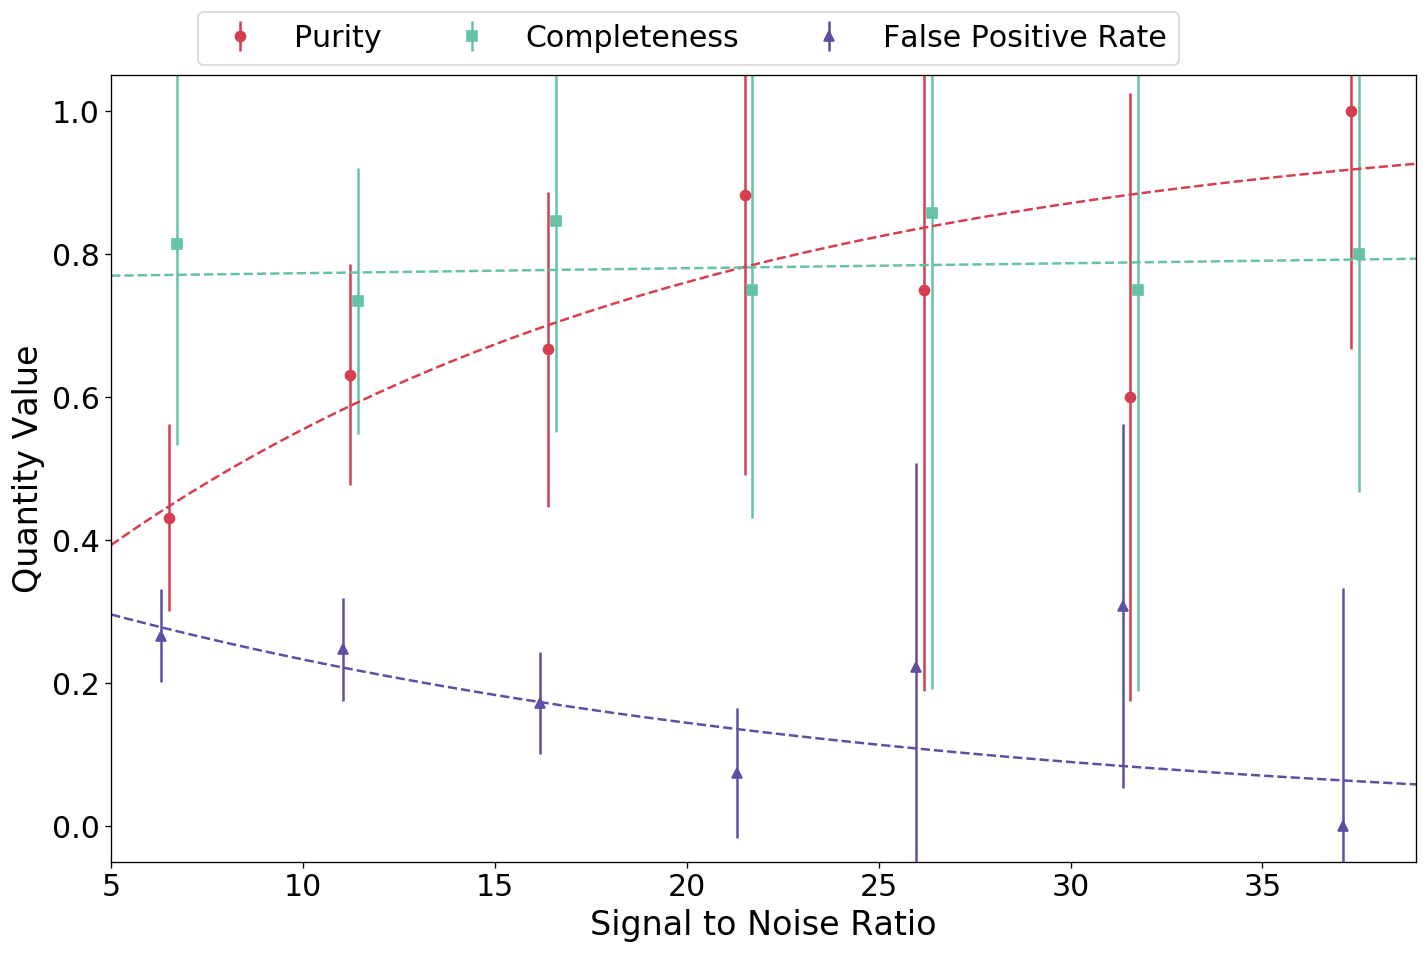

In [54]:
plt.figure(figsize=(12,8), dpi=120)

plt.errorbar(mean_snr, purity, yerr=purity_err, fmt='o',c='#d53e4f',label='Purity')
plt.plot(basis, best_fit_purity,c='#d53e4f',linestyle='--')

plt.errorbar(mean_snr+0.2, completeness, yerr=completeness_err, fmt='s',c='#66c2a5',label='Completeness')
plt.plot(basis, best_fit_completeness,c='#66c2a5',linestyle='--')

plt.errorbar(mean_snr-0.2, fpr, yerr=fpr_err, fmt='^',c='#5e4fa2',label='False Positive Rate')
plt.plot(basis, best_fit_fpr,c='#5e4fa2',linestyle='--')

plt.ylim(-.05,1.05)
plt.xlim(5,39)
plt.xlabel('Signal to Noise Ratio',fontsize=20)
plt.ylabel('Quantity Value',fontsize=20)
plt.legend(ncol=3, loc='upper left', bbox_to_anchor=[0.055, 1.1],fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('snr.pdf')
plt.show()

In [ ]:
tp = np.sum((centers > center_thres) & ((md_test.ACTION != 'DarkSpotInTemplateCenter') & (md_test.ACTION != 'NoisyTemplate')))
fn = np.sum((centers < center_thres) & ((md_test.ACTION != 'DarkSpotInTemplateCenter') & (md_test.ACTION != 'NoisyTemplate')))
fp = np.sum((centers > center_thres) & ((md_test.ACTION == 'DarkSpotInTemplateCenter') | (md_test.ACTION == 'NoisyTemplate')))
center_completeness = (tp / (tp + fn))
center_purity = tp / (tp + fp)

Text(0, 0.5, 'Prob')

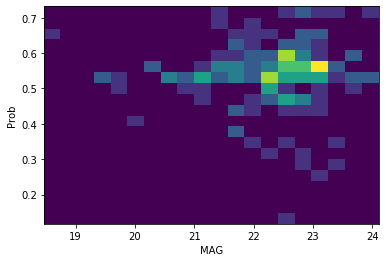

In [36]:
mags = 27.5 - 2.5 * np.log10(np.where(md_test["FLUXCAL"].values < 1.0, 1.0, md_test["FLUXCAL"].values))

plt.hist2d(mags[md_test.loc[md_test['ACTION'] == 'Good'].index], prob_class0[:,0], bins=20)
plt.xlabel('MAG')
plt.ylabel('Prob')

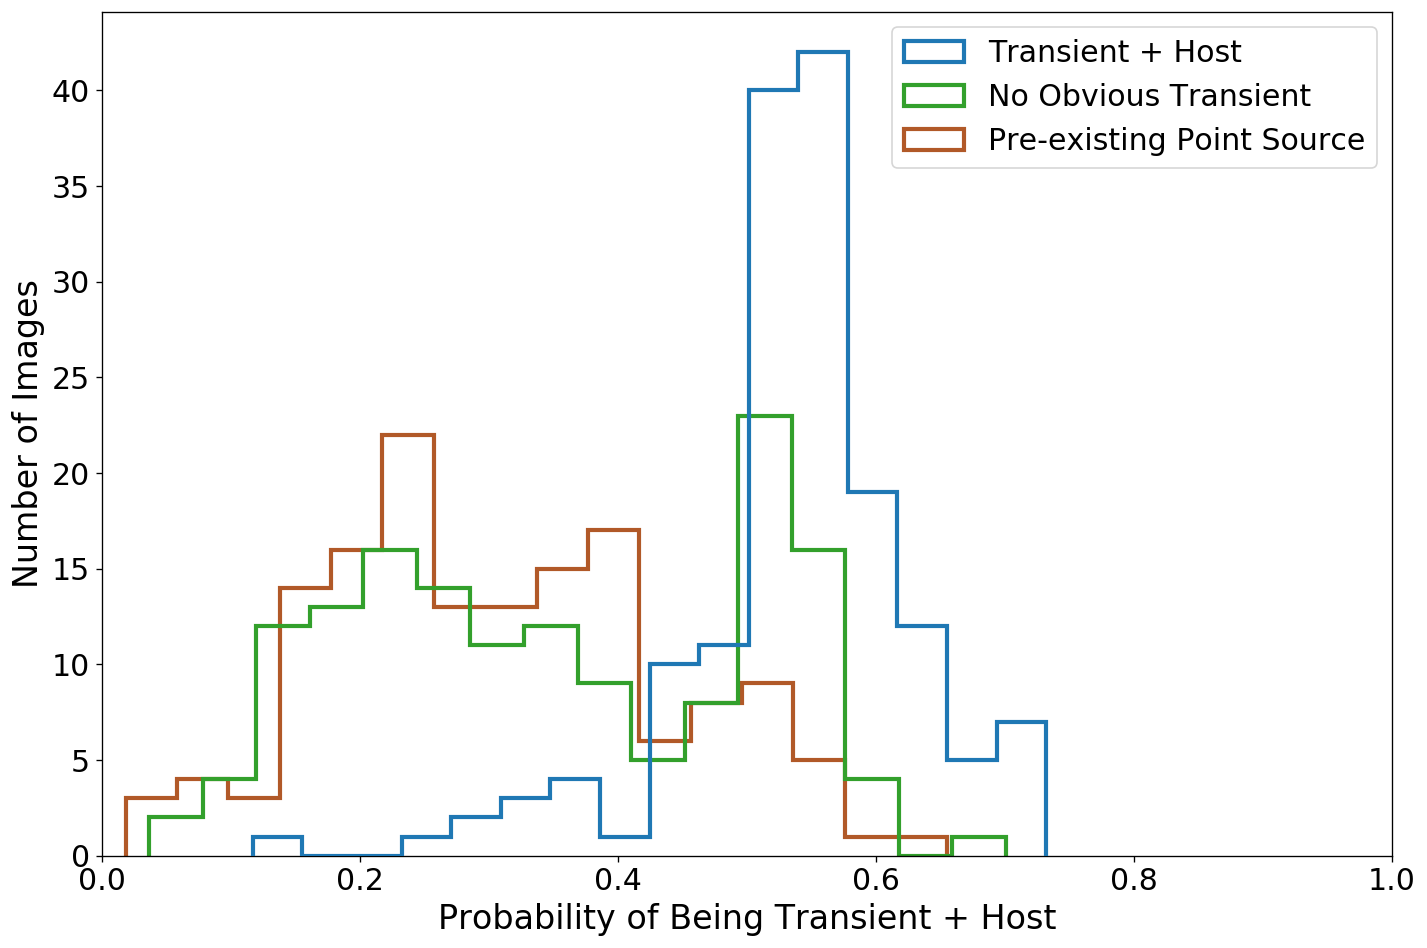

In [39]:
plt.figure(figsize=(12,8), dpi=120)
#plt.hist(prob_class0[:,0], density=True, label="Good", histtype="step", range=(0.4,0.7), lw=2, bins=30)
plt.hist(prob_class0[:,0],label= "Transient + Host",histtype="step",lw=2.5,color='#1F78B4',bins=16,zorder=3)
plt.hist(prob_class1[:,0],label= "No Obvious Transient",histtype="step",lw=2.5,color='#33A02C',bins=16,zorder=2)
#plt.hist(prob_class3[:,0], label= "Bad Sub", histtype="step", lw=2, bins=20)
#plt.axvline(0.485, c="red", lw=2.5)
#plt.hist(prob_class4[:,0], label = "Noisy + Dark Spot", histtype="step", lw=2, bins=20)
plt.hist(prob_class6[:,0],label = "Pre-existing Point Source",histtype="step",lw=2.5,color='#B15928',bins=16,zorder=1)
plt.xlabel("Probability of being good")
plt.ylabel("Counts")
plt.xlim(0,1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Probability of Being Transient + Host',fontsize=20)
plt.ylabel('Number of Images',fontsize=20)
plt.legend(loc="upper right", fontsize=18)
plt.tight_layout()
plt.savefig('Class_Histogram.pdf')

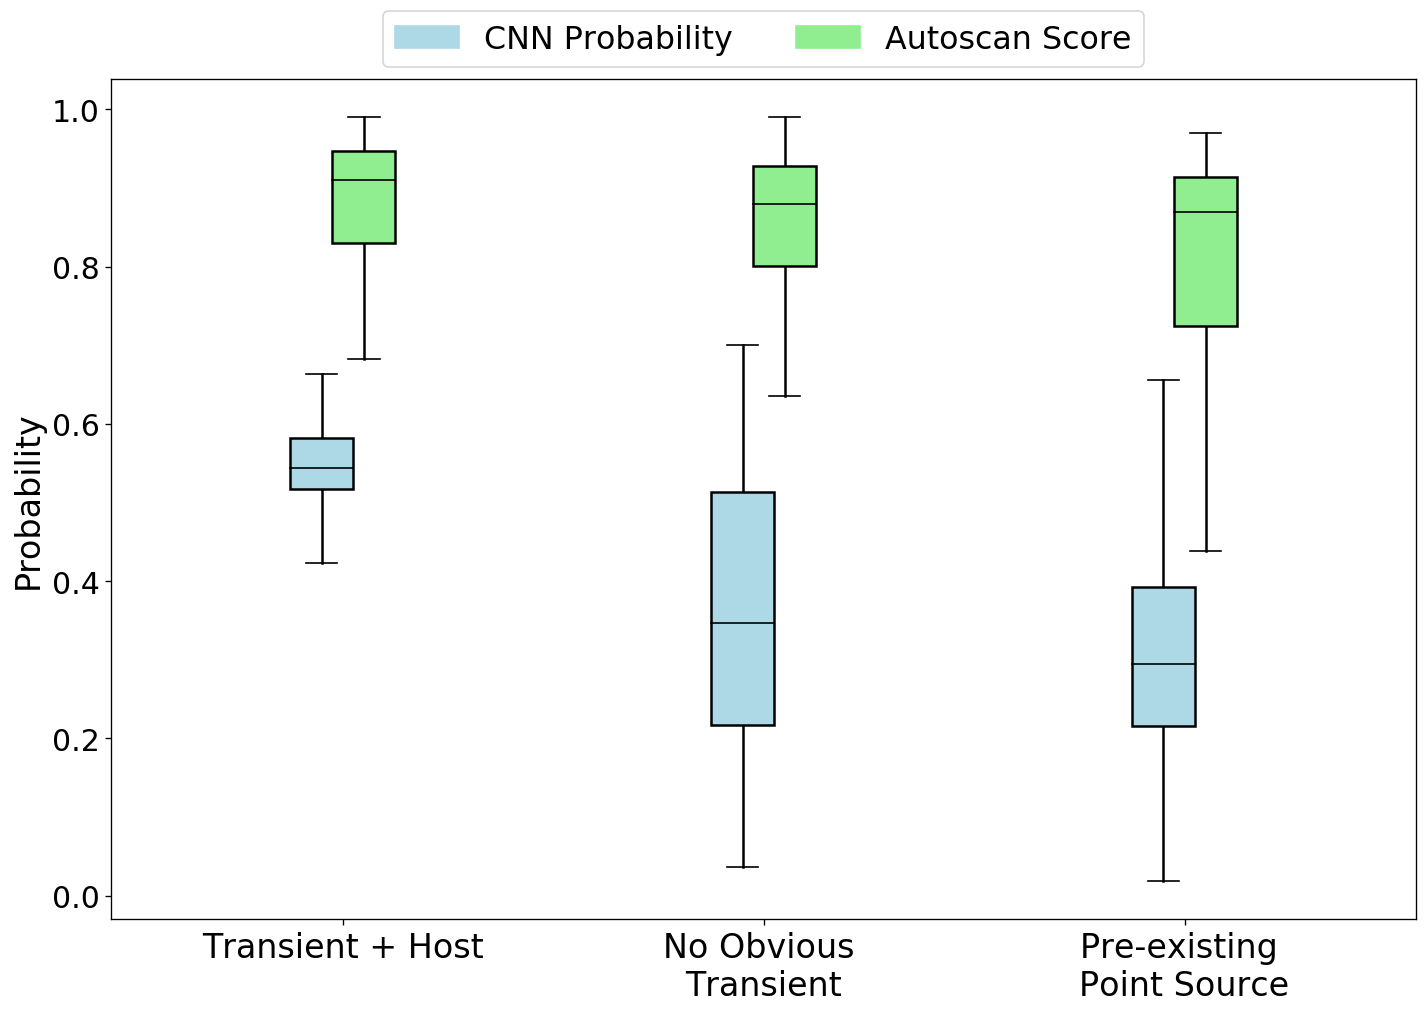

In [70]:
import matplotlib.patches as mpatches
lightblue_patch = mpatches.Patch(color='lightblue', label='CNN Probability')
lightgreen_patch = mpatches.Patch(color='lightgreen', label='Autoscan Score')

medianprops = dict(color="black",linewidth=1)
boxprops=dict(linewidth=1.5)
whiskerprops=dict(linewidth=1.5)

plt.figure(figsize=(12,8.5), dpi=120)
bp1 = plt.boxplot(prob_class0[:,0], positions=[1],showfliers=False, labels=['Good'], patch_artist=True, medianprops=medianprops,whiskerprops=whiskerprops,boxprops=boxprops)
bp2 = plt.boxplot(md_test.loc[md_test['ACTION'] == 'Good'].PHOTPROB, positions=[1.1],showfliers=False, patch_artist=True, medianprops=medianprops,whiskerprops=whiskerprops,boxprops=boxprops)
bp3 = plt.boxplot(prob_class1[:,0], positions=[2],showfliers=False, labels=['Marginal'], patch_artist=True, medianprops=medianprops,whiskerprops=whiskerprops,boxprops=boxprops)
bp4 = plt.boxplot(md_test.loc[md_test['ACTION'] == 'Marginal'].PHOTPROB, positions=[2.1],showfliers=False, patch_artist=True, medianprops=medianprops,whiskerprops=whiskerprops,boxprops=boxprops)
bp5 = plt.boxplot(prob_class6[:,0], positions=[3],showfliers=False, labels=['Point Source'], patch_artist=True, medianprops=medianprops,whiskerprops=whiskerprops,boxprops=boxprops)
bp6 = plt.boxplot(md_test.loc[md_test['ACTION'] == 'PsfInTemplate'].PHOTPROB, positions=[3.1],showfliers=False, patch_artist=True, medianprops=medianprops,whiskerprops=whiskerprops,boxprops=boxprops)
plt.xticks([1.05, 2.05, 3.05], ['Transient + Host', 'No Obvious \nTransient', 'Pre-existing \nPoint Source'], fontsize=20)
plt.legend(ncol=2,loc='upper left',handles=[lightblue_patch, lightgreen_patch], fontsize=19, bbox_to_anchor=[0.196, 1.1])
plt.yticks(fontsize=18)
plt.ylabel('Probability',fontsize=20)

colors = ['lightblue']
for bplot in (bp1, bp3, bp5):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
colors = ['lightgreen']
for bplot in (bp2, bp4, bp6):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.tight_layout()
plt.savefig('AutoscanComparison.pdf')